In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pickle
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from scipy.special import factorial
import copy as cp
from PIL import Image

/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pillow_to_numpy(image):
    image = np.asarray(image, dtype=np.float32)
    return image
def numpy_to_pillow(image):
    image = Image.fromarray(image.astype(np.uint8))
    return image

## Cifar-10 데이터 불러오는 부분

In [3]:
def unPickle(file):
    with open(file, 'rb') as file:
        data = pickle.load(file, encoding='bytes')
    return data

root_dir = '' ## 이미지 데이터 경로
train_data = sorted(glob(root_dir + "/data_batch_*"))
test_data = sorted(glob(root_dir + "/test_batch"))

classes = unPickle(glob(root_dir + "/batches.meta")[0])[b'label_names']

train_img, train_label = [], []
for batch in train_data:
    temp = unPickle(batch)
    train_img.append(temp[b'data'])
    train_label.append(temp[b'labels'])

test_img, test_label = [], []
for batch in test_data:
    temp = unPickle(batch)
    test_img.append(temp[b'data'])
    test_label.append(temp[b'labels'])

train_img = np.array(train_img).reshape(-1, 32*32*3) / 1.0
R = train_img[:, :1024]
G = train_img[:, 1024:2048]
B = train_img[:, 2048:]
train_img = np.dstack((R, G, B)).reshape(-1, 32, 32, 3)
train_label = np.array(train_label).reshape(-1)

test_img = np.array(test_img).reshape(-1, 32*32*3) / 1.0
R = test_img[:, :1024]
G = test_img[:, 1024:2048]
B = test_img[:, 2048:]
test_img = np.dstack((R, G, B)).reshape(-1, 32, 32, 3)
test_label = np.array(test_label).reshape(-1)

In [4]:
print(train_img[0].shape)

(32, 32, 3)


## DP-SVD 처리 함수

In [5]:
def dk_privacy_I2(image, epsilon):
    return np.sqrt(np.square(image)).sum(axis=0)/epsilon

def dk_privacy(image, k, epsilon):
    sampling_1 = 1/2 * np.power(epsilon/np.sqrt(np.pi), k) * factorial(k/1)/factorial(k-1) * np.exp(-epsilon * np.sqrt(np.square(image)).sum(axis=0))
    while True:
        derivative = dk_privacy_I2(sampling_1, epsilon)
        sampling_1 -= derivative
        if derivative <= 1e-10:
            break

    return sampling_1

def get_random_samples_on_N_sphere(N, R, number_of_samples):
    X = np.random.default_rng().normal(size=(number_of_samples, N))
    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

def trans_privacy(image, k, epsilon):
    index = np.argpartition(image, -k)[-k:]
    top_k = image[index]
    trans_vector = dk_privacy(top_k, k, epsilon)
    radial = get_random_samples_on_N_sphere(k, trans_vector, 1)
    result_vector = top_k + radial * trans_vector
    trans_image = np.zeros_like(image)
    trans_image[index] = result_vector
    
    return trans_image

def img_svd(image, k, epsilon):
    red, green, blue = cp.deepcopy(image[:, :, 0]), cp.deepcopy(image[:, :, 1]), cp.deepcopy(image[:, :, 2])

    U_red, S_red, V_red = svd(red, full_matrices=False)
    U_green , S_green, V_green = svd(green, full_matrices=False)
    U_blue, S_blue, V_blue = svd(blue, full_matrices=False)

    trans_red = trans_privacy(S_red, k, epsilon)
    trans_green = trans_privacy(S_green, k, epsilon)
    trans_blue = trans_privacy(S_blue, k, epsilon)

    final_red = U_red @ (np.diag(trans_red) @ V_red)
    final_green = U_green @ (np.diag(trans_green) @ V_green)
    final_blue = U_blue @ (np.diag(trans_blue) @ V_blue)

    final_image = np.zeros(image.shape)

    final_image[:,:,0], final_image[:,:,1], final_image[:,:,2] = final_red, final_green, final_blue

    for i in range(len(final_image)):
        for j in range(len(final_image[i])):
            for w in range(len(final_image[i][j])):
                final_image[i, j , w] = min(255, abs(final_image[i, j, w]))
    
    final_image = final_image.astype(np.uint8)

    return final_image

## 이미지 샘플링

In [6]:
print(f"Training Set: {len(train_img)}")
print(f"Training Labels: {np.unique(train_label)}")
for label, label_name in zip(np.unique(train_label), classes):
    print(f"label {label} ({label_name.decode()}) = {list(train_label).count(label)}")

print(f"Training Set: {len(test_img)}")
print(f"Training Labels: {np.unique(test_label)}")
for label, label_name in zip(np.unique(test_label), classes):
    print(f"label {label} ({label_name.decode()}) = {list(test_label).count(label)}")

Training Set: 50000
Training Labels: [0 1 2 3 4 5 6 7 8 9]
label 0 (airplane) = 5000
label 1 (automobile) = 5000
label 2 (bird) = 5000
label 3 (cat) = 5000
label 4 (deer) = 5000
label 5 (dog) = 5000
label 6 (frog) = 5000
label 7 (horse) = 5000
label 8 (ship) = 5000
label 9 (truck) = 5000
Training Set: 10000
Training Labels: [0 1 2 3 4 5 6 7 8 9]
label 0 (airplane) = 1000
label 1 (automobile) = 1000
label 2 (bird) = 1000
label 3 (cat) = 1000
label 4 (deer) = 1000
label 5 (dog) = 1000
label 6 (frog) = 1000
label 7 (horse) = 1000
label 8 (ship) = 1000
label 9 (truck) = 1000


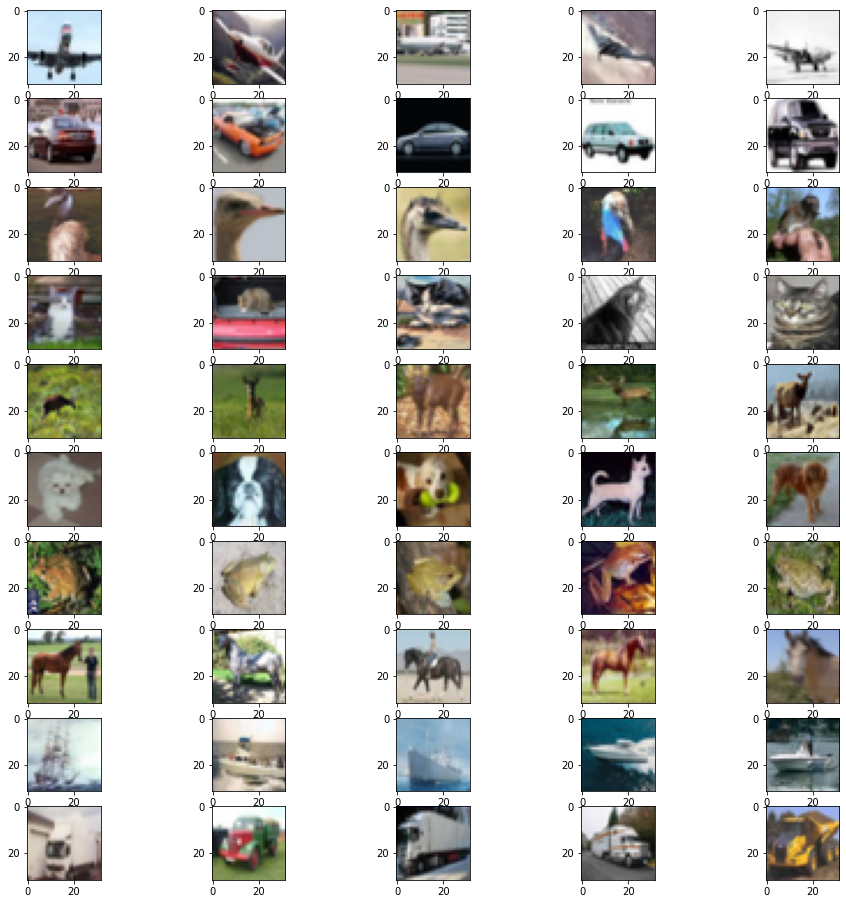

In [6]:
fig = plt.figure(figsize=(16, 16))

row = len(np.unique(train_label))
col = 5

for label in range(row):
    indices = np.random.choice(np.where(train_label == label)[0], col)
    for i in range(col):
        img = train_img[indices[i]] / 255.0
        fig.add_subplot(row, col, i+col*label + 1)
        plt.imshow(img)
plt.show()

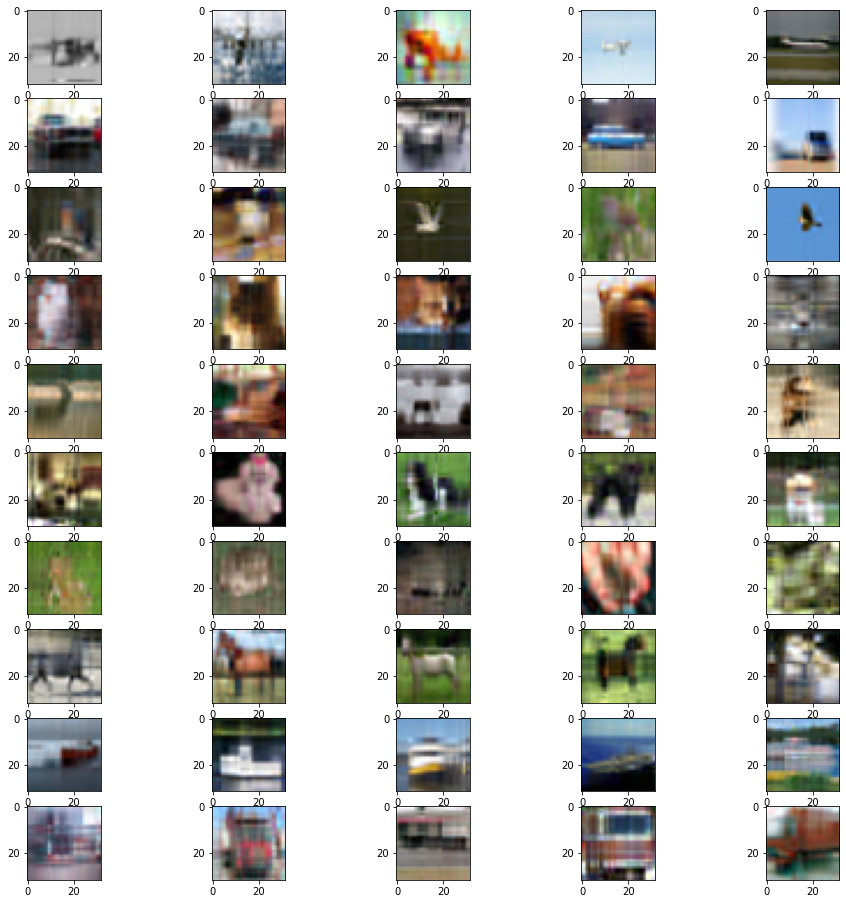

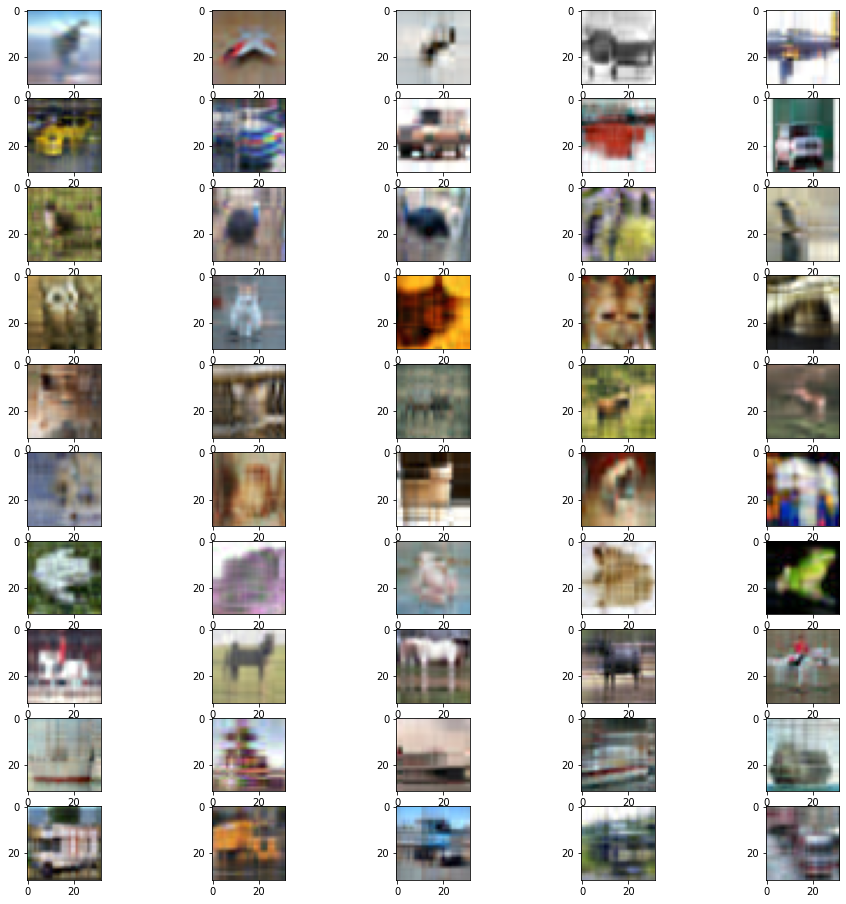

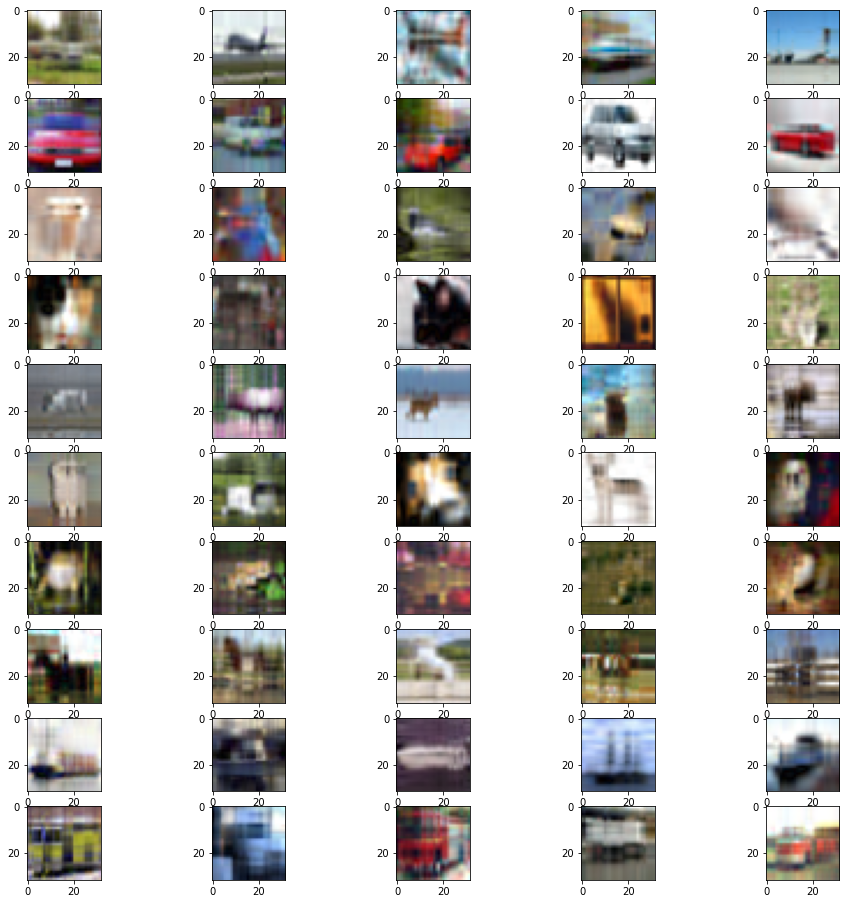

In [7]:
fig = plt.figure(figsize=(16, 16))

row = len(np.unique(train_label))
col = 5

k = 4
epsilon = 0.01
for label in range(row):
    indices = np.random.choice(np.where(train_label == label)[0], col)
    for i in range(col):
        img = img_svd(train_img[indices[i]], k, epsilon)
        fig.add_subplot(row, col, i+col*label + 1)
        plt.imshow(img)
plt.show()

fig = plt.figure(figsize=(16, 16))

row = len(np.unique(train_label))
col = 5

k = 4
epsilon = 0.1
for label in range(row):
    indices = np.random.choice(np.where(train_label == label)[0], col)
    for i in range(col):
        img = img_svd(train_img[indices[i]], k, epsilon)
        fig.add_subplot(row, col, i+col*label + 1)
        plt.imshow(img)
plt.show()


fig = plt.figure(figsize=(16, 16))

row = len(np.unique(train_label))
col = 5

k = 4
epsilon = 1.0
for label in range(row):
    indices = np.random.choice(np.where(train_label == label)[0], col)
    for i in range(col):
        img = img_svd(train_img[indices[i]], k, epsilon)
        fig.add_subplot(row, col, i+col*label + 1)
        plt.imshow(img)
plt.show()

## SVD 이미지 생성

In [9]:
k = 4
epsilon = 0.1

n = len(np.unique(train_label))

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

root_dir = "/media/data2/hyunjun/content/"
train_root = root_dir + "origin-cifar-10/train/"
test_root = root_dir + "origin-cifar-10/test/"
svd_train_root = root_dir + "svd4-cifar-10/train/"
svd_test_root = root_dir + "svd4-cifar-10/test/"

for label in range(n):
    indices = np.where(train_label == label)[0]
    for index in range(len(indices)):
        img1 = img_svd(train_img[indices[index]], k, epsilon)
        #img2 = train_img[indices[index]].astype('uint8')
        img1 = Image.fromarray(img1, 'RGB')
        #img2 = Image.fromarray(img2, 'RGB')
        img1.save(svd_train_root + classes[label] + "/" + classes[label] + str(index) + ".jpg")
        #img2.save(train_root + classes[label] + "/" + classes[label] + str(index) + ".jpg")
        
for label in range(n):
    indices = np.where(test_label == label)[0]
    for index in range(len(indices)):
        img1 = img_svd(test_img[indices[index]], k, epsilon)
        #img2 = test_img[indices[index]].astype('uint8')
        img1 = Image.fromarray(img1, 'RGB')
        #img2 = Image.fromarray(img2, 'RGB')
        img1.save(svd_test_root + classes[label] + "/" + classes[label] + str(index) + ".jpg")
        #img2.save(test_root + classes[label] + "/" + classes[label] + str(index) + ".jpg")